# Introduction

The selected dataset, Global Protest Tracker, is a collection of protests from all over the world since 2017. Some of which are still active. 

This dataset has been downloaded from Kaggle and was originally sourced from https://carnegieendowment.org/. An organisation that aims to collect and analyse data from a non-partisan perspective in the hope of contributing to a more peaceful world.

The aim of this project is to discover any trends in global protests, what makes them more likely to occur and if there are any factors which determine how long they may go on for or if they become violent.

## Import modules

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from scipy.stats import chi2_contingency
from statistics import variance
from scipy.stats import ttest_ind

## Import and Inspect Data

In [41]:
#load csv into pandas dataframe
df = pd.read_csv("GlobalProtestTracker.csv")
#df.head()

### Get columns

In [42]:
df.columns

Index(['Country', 'Protest Name', 'Start Date', 'Freedom Rating (Status)',
       'Triggers', 'Motivations', 'Peak Size', 'Key Participants', 'Duration',
       'Outcomes', 'Active protests', 'Economic motivation?',
       'Political motivation?', 'Corruption motivation?', 'Size category',
       'Protests with a significant outcome',
       'Large protests (Over 100,000 protesting)',
       'Violent government response', 'Long protests (more than 3 months)',
       'Coronavirus-related protests', 'Capital city'],
      dtype='object')

### Identify missing data

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Country                                   329 non-null    object
 1   Protest Name                              329 non-null    object
 2   Start Date                                329 non-null    object
 3   Freedom Rating (Status)                   329 non-null    object
 4   Triggers                                  329 non-null    object
 5   Motivations                               329 non-null    object
 6   Peak Size                                 329 non-null    object
 7   Key Participants                          328 non-null    object
 8   Duration                                  329 non-null    object
 9   Outcomes                                  328 non-null    object
 10  Active protests                           17 non-n

It looks like categories related to motivation, significant outcome, violent response, length > 3 months, coronavirus-related are all formatted with an "X" if true and left blank if false. 

To make this easier to work with I could convert the Xs to 1 and the null values to 0.

There also appear to be a few values missing, where there should be 329 values but there are only 328. Notably "key participants", "outcomes", "capital city". 

Let's try to find out why that might be.

#### Explore Key Participants

In [44]:
#get unique values for Key Participants and the number of unique values
# print(df["Key Participants"].unique())
# print(df["Key Participants"].nunique())

In [45]:
#get the null value row for Key Participants
#df[df["Key Participants"].isnull()]

It looks like this kind of protest could have been largely participated in by the general public. A quick glance at the unique values for "key participants" shows that each value is really a list, most of which include "General public". Let's see how many of the 329 values included the general public as participants.

In [46]:
#df["Key Participants"].describe()

I can see however that some entries mention the General Public amongst other categories. Let's find the real number.

In [47]:
#create function that counts all instances of "General Public" in Key Participants
def count_gp(df):
    res = df["Key Participants"].str.findall(r"(general public)", flags = re.IGNORECASE)
    count = 0
    for x in res:
        if "general public"in str(x).lower():
            count += 1
    return count

count_gp(df)

190

In [48]:
#calculate percent that include General Public
pct_gp = count_gp(df)/len(df)*100
pct_gp

57.75075987841946

57% of protests included General Public as a category of people involved. Although many other categories could be classed as more specific groups of the general public, such as "Residents of". Not really enough to confidently assume the public would be involved in any given protest on it's own. But due to the amount of categories in Key Participants, I won't be classifying any data by this category anyway, plus it's only 1 datapoint. So I will likely fill with General public.

#### Explore Outcomes

In [49]:
#get the null value row for Outcomes
#df[df["Outcomes"].isnull()]

The second null category that shouldn't be there is also Zimbabwe but a different entry. If it were the same entry, I would be much more likely to drop the datapoint. As it's different I would like to try and keep both otherwise face losing 2 Zimbabwe pieces of data. Let's see what other types of outcomes there were.

In [50]:
#df["Outcomes"].describe()

It looks like the most common value is that there was no change as a result of the protests which one could argue looks quite similar to NaN, in this case. I will likely fill this with No policy/leadership change.

#### Explore Capital city

In [51]:
#get the null value row for Captial city
#df[df["Capital city"].isnull()]

I can simply google this and find that the capital city of Togo is Lomé.

## Data Cleaning

### Fill the 3 investigated null values with appropriate values

In [52]:
df["Key Participants"].fillna(df["Key Participants"].describe().top, inplace = True)
df["Outcomes"].fillna(df["Outcomes"].describe().top, inplace = True)
df["Capital city"].fillna("Lomé", inplace = True)

In [53]:
#check these 3 nulls were populated
#df.info()

### Replace the rest of the null values with binary values for each category

In [54]:
#replace X with 1 and NaN with 0
df.replace({"X" : 1, np.nan : 0}, inplace = True)

In [55]:
#check we have populated the df with 1s and 0s for necessary categories
#df.info()

All of the categories that contained null values mixed with "X" for False or True, now have numerical values instead.

### Check for duplicates

In [56]:
df.drop_duplicates(inplace = True)
#df.info()

There are still 329 entries so there were no duplicates in the dataset

### Clean Size category column

In [57]:
#check unique values in Size category
df["Size category"].unique()

array(['Thousands', 'Tens of thousands', 'Hundreds of thousands',
       'Over 1 million', 'Hundreds', 'Millions',
       'Hundreds of of thousands', 'Unknown', 'Huundreds of thousands',
       'Tens of millions', 'Thosuands'], dtype=object)

In [58]:
#correct spelling mistakes and consolidate
df["Size category"] = df["Size category"].replace({"Huundreds of thousands" : "Hundreds of thousands",\
            "Thosuands" : "Thousands",\
            "Hundreds of of thousands" : "Hundreds of thousands",\
            "Over 1 million" : "Millions"})

In [59]:
#change to category dtype
size_order = ["Hundreds",
              "Thousands", 
              "Tens of thousands", 
              "Hundreds of thousands",
              "Millions",
              "Tens of millions",
              "Unknown"]

df["Size category"] = df["Size category"].astype("category").cat.set_categories(size_order, ordered=True)

### Clean Duration column

In [60]:
#df["Start Date"].unique()

In [61]:
df["Start Date"] = df["Start Date"].replace("Feb-2018", "Feb-18")

In [62]:
#df["Duration"].unique()

In [63]:
#define function to count days between 2 dates
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%b-%y")
    d2 = datetime.strptime(d2, "%b-%y")
    return abs((d2 - d1).days)

#define function to clean the protest duration column
def clean_duration(row):
    n = row["Duration"]
    #set default values
    year_days = 0
    month_days = 0
    week_days = 0
    days = 0
    #compile regex
    yr = re.findall(r"year[,s]*", n)
    mt = re.findall(r"month[,s]*", n)
    wk = re.findall(r"week[,s]*", n)
    dy = re.findall(r"day[,s]*", n)
    #if entry is not "Active" and contains years, months, weeks or days, multiply amount by relevant day numbers
    if row["Duration"] != "Active":
        if yr:
            year_index = n.split(" ").index(yr[0])
            num_years_index = year_index - 1
            year_days = int(n.split(" ")[num_years_index]) * 365
        if mt:
            month_index = n.split(" ").index(mt[0])
            num_months_index = month_index - 1
            month_days = int(n.split(" ")[num_months_index]) * 30
        if wk:
            week_index = n.split(" ").index(wk[0])
            num_weeks_index = week_index - 1
            week_days = int(n.split(" ")[num_weeks_index]) * 7
        if dy:
            day_index = n.split(" ").index(dy[0])
            num_days_index = day_index - 1
            days = int(n.split(" ")[num_days_index])
        #sum numbers to get a total amount of protest days    
        res = year_days + month_days + week_days + days
        return res
    else:
        #else will be "Active" so return number of days between start date and analysis start date
        return days_between(row["Start Date"], "Jul-22")


#run cleaning functions
df["Duration"] = df.apply(lambda row: clean_duration(row), axis = 1)
df.rename(columns = {"Duration" : "Duration (Days)"}, inplace = True)

### Clean Freedom Rating column

In [64]:
#rename column name
df.rename(columns={"Freedom Rating (Status)":"Freedom Rating"}, inplace = True)
#check unique values
df["Freedom Rating"].unique()

array(['Free', 'Partly free', 'Not free', 'Partly freee'], dtype=object)

In [65]:
#replace misspelled value
df["Freedom Rating"] = df["Freedom Rating"].replace({"Partly freee":"Partly free"})

In [66]:
#change to category type
freedom_order = [
    "Free",
    "Partly free",
    "Not free"
]

df["Freedom Rating"] = df["Freedom Rating"].astype("category").cat.set_categories(freedom_order, ordered=True)

## Explore Data

In [67]:
df.describe(include = "all")

,Country,Protest Name,Start Date,Freedom Rating,Triggers,Motivations,Peak Size,Key Participants,Duration (Days),Outcomes,...,Economic motivation?,Political motivation?,Corruption motivation?,Size category,Protests with a significant outcome,"Large protests (Over 100,000 protesting)",Violent government response,Long protests (more than 3 months),Coronavirus-related protests,Capital city
count,329,329,329,329,329,329,329,329,329.000000,329,...,329.000000,329.000000,329.000000,329,329.000000,329.000000,329.000000,329.000000,329.000000,329
unique,126,263,65,3,327,322,53,174,NaN,119,...,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,125
top,France,Corruption protests,Oct-19,Partly free,Ongoing pandemic-related restrictions.,Frustration with ongoing coronavirus restricti...,">1,000",General public.,NaN,No policy/leadership change in response to the...,...,NaN,NaN,NaN,Thousands,NaN,NaN,NaN,NaN,NaN,Paris
freq,11,9,16,118,2,4,107,127,NaN,84,...,NaN,NaN,NaN,154,NaN,NaN,NaN,NaN,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.537994,NaN,...,0.355623,0.869301,0.200608,NaN,0.300912,0.151976,0.273556,0.243161,0.145897,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173.750643,NaN,...,0.479431,0.337584,0.401065,NaN,0.459353,0.359544,0.446463,0.429645,0.353540,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,...,0.000000,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.000000,NaN,...,0.000000,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.000000,NaN,...,1.000000,1.000000,0.000000,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,NaN


The only column with numerical values is now the Duration (Days) column. The rest are either Categorical, nominal or binary categorical. 

### Size Category by Number of Protests

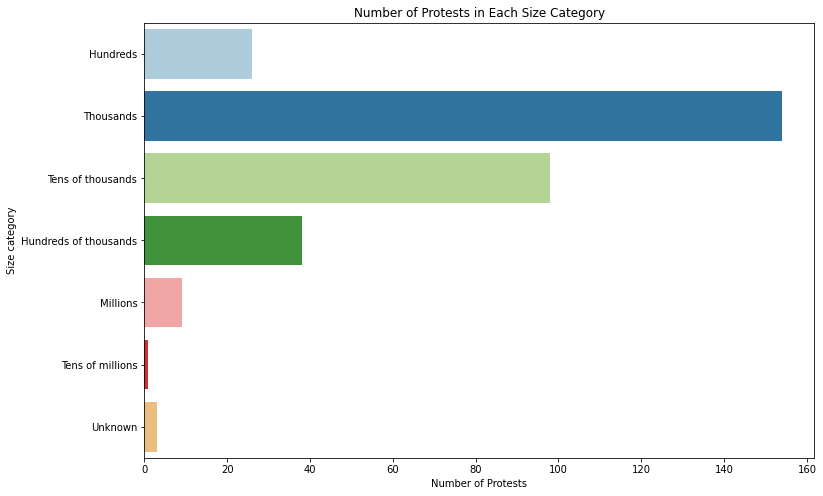

In [68]:
fig = plt.figure(figsize = (12,8))
sns.countplot(data = df, y = df["Size category"], palette = "Paired")
plt.title("Number of Protests in Each Size Category")
plt.xlabel("Number of Protests")
plt.show()

### Size Category by Freedom Rating and Number of Protests

In [69]:
#isolate columns
size_counts = df[["Freedom Rating", "Size category"]]
#get dummies for Size category and group by Freedom Rating
size_counts = pd.get_dummies(size_counts, columns = ["Size category"], prefix = "dmy").groupby("Freedom Rating").sum().reset_index()
#melt to long form for graphing
size_counts = size_counts.melt(id_vars="Freedom Rating")

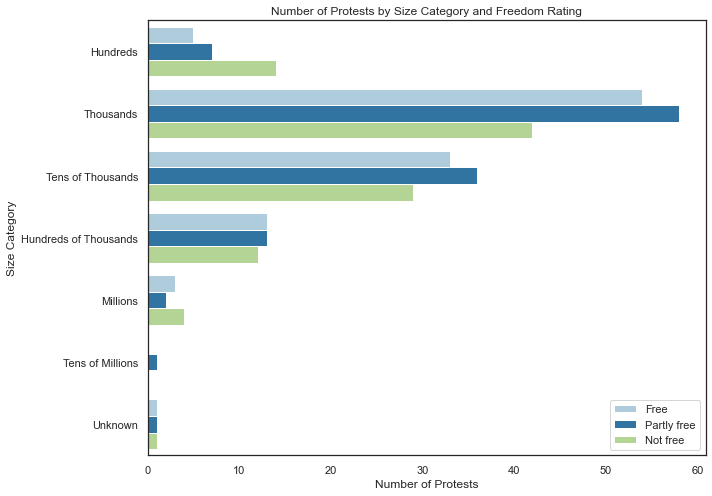

In [117]:
fig = plt.figure(figsize = (10, 8))
ax = sns.barplot(data = size_counts, 
                 y = "variable", 
                 x = "value", 
                 hue = "Freedom Rating", 
                 palette = "Paired")

yticks = ["Hundreds", 
          "Thousands", 
          "Tens of Thousands", 
          "Hundreds of Thousands", 
          "Millions", 
          "Tens of Millions", 
          "Unknown"]

plt.xlabel("Number of Protests")
plt.ylabel("Size Category")
plt.title("Number of Protests by Size Category and Freedom Rating")
ax.set_yticklabels(yticks)
plt.legend(loc = "lower right")
plt.savefig("Protest Size Category by Freedom Rating", bbox_inches='tight')
plt.show()

### Distribution of Duration

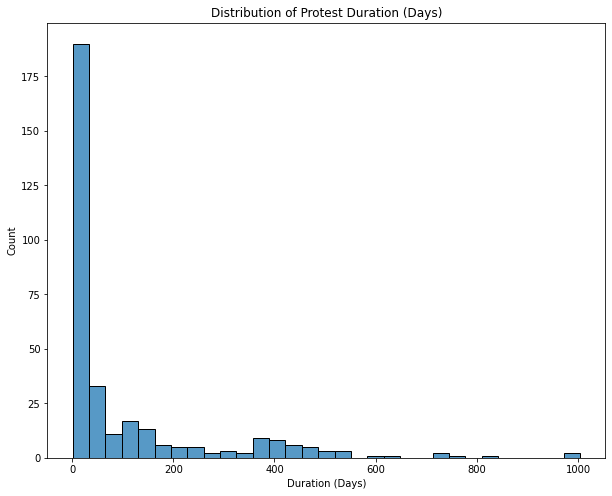

In [71]:
#plot histogram of protest durations
fig = plt.figure(figsize = (10, 8))
sns.histplot(df["Duration (Days)"])
plt.title("Distribution of Protest Duration (Days)")
plt.show()

#### Find outliers

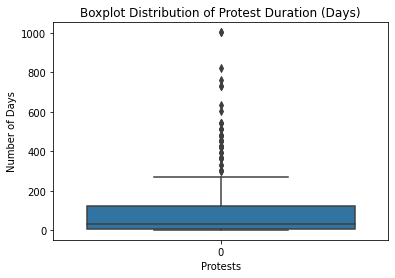

In [72]:
#plot boxplot to examine median, IQR and outliers
sns.boxplot(data = df["Duration (Days)"])
plt.xlabel("Protests")
plt.ylabel("Number of Days")
plt.title("Boxplot Distribution of Protest Duration (Days)")
plt.show()

We can see the outliers of the duration column on the above boxplot. 

These could be affect some of the analysis I want to do on the Duration of protests vs Freedom Rating, so I will cap the outliers at 95th percentile. This will also retain the integrity of the column "Long protests (over 3 months)"and the data within it.

#### Cap Outliers to 95th percentile

In [73]:
#define 95th percentile
ninty_fifth_pct = np.percentile(df["Duration (Days)"], 95)

#change data to be capped at 95th percentile
df["Duration (Days)"] = np.where(df["Duration (Days)"] > ninty_fifth_pct, ninty_fifth_pct, df["Duration (Days)"])

#### Plot new distribution

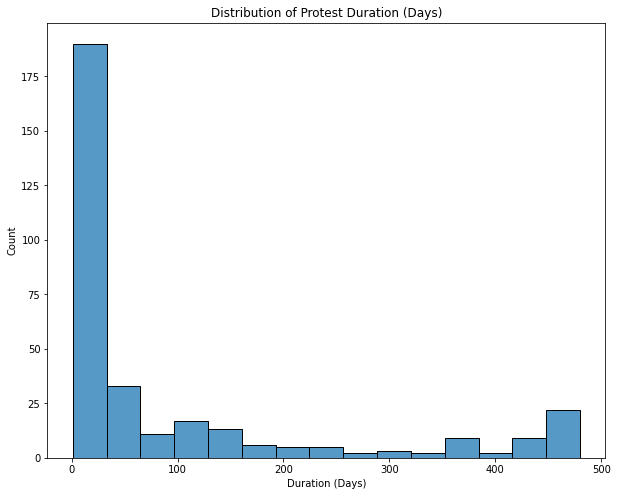

In [74]:
fig = plt.figure(figsize = (10, 8))
sns.histplot(df["Duration (Days)"])
plt.title("Distribution of Protest Duration (Days)")
plt.savefig("Distribution of Protest Duration")
plt.show()

In [115]:
#find median duration + other summary stats
df["Duration (Days)"].describe()

count    329.000000
mean     100.151976
std      145.085534
min        1.000000
25%        7.000000
50%       30.000000
75%      120.000000
max      480.000000
Name: Duration (Days), dtype: float64

### Protest Duration by Freedom Rating

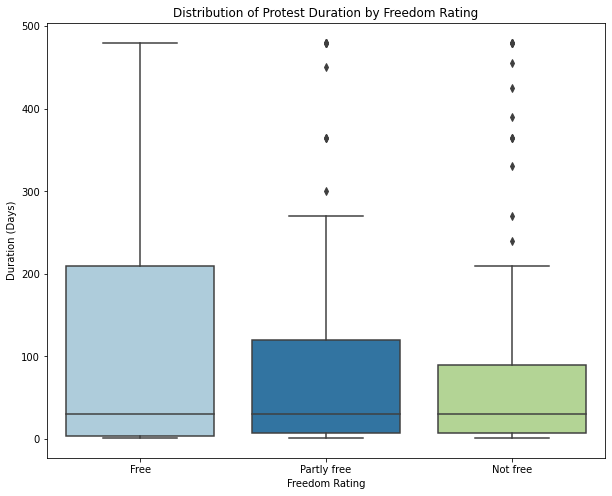

In [76]:
plt.figure(figsize = (10, 8))
sns.boxplot (data = df, 
             x = "Freedom Rating", 
             y = "Duration (Days)", 
             showfliers = True, 
             palette = "Paired")
plt.title("Distribution of Protest Duration by Freedom Rating")
plt.savefig("Protest Duration by Freedom Rating")
plt.show()

#### Get summary statistics for Freedom Rating categories

In [77]:
#loop through each category in Freedom Rating and print summary statistics
for n in df["Freedom Rating"].unique():
    print(n + ":", 
          f"Sum = {len(df[df['Freedom Rating'] == n]['Duration (Days)'])}",
          f"IQR = {(np.percentile(df[df['Freedom Rating'] == n]['Duration (Days)'], 75)) - (np.percentile(df[df['Freedom Rating'] == n]['Duration (Days)'], 25))}"
          )

Free: Sum = 109 IQR = 207.0
Partly free: Sum = 118 IQR = 113.0
Not free: Sum = 102 IQR = 83.0


#### Findings

There are roughly the same amount of protests in each category.

We can see by the distribution of the 3 categories: Free, Partly free and Not free, that as countries become classed as less free - the protests reported durations are generally shorter.

### Motivation vs Freedom Rating

In [78]:
#group df by freedom rating
freedom_counts = df.groupby("Freedom Rating").sum("Country")
#melt new df for graphing
motivation_counts = freedom_counts[["Economic motivation?",
                                    "Political motivation?",
                                    "Corruption motivation?",
                                    "Coronavirus-related protests"]].reset_index().melt(id_vars = "Freedom Rating")

#motivation_counts

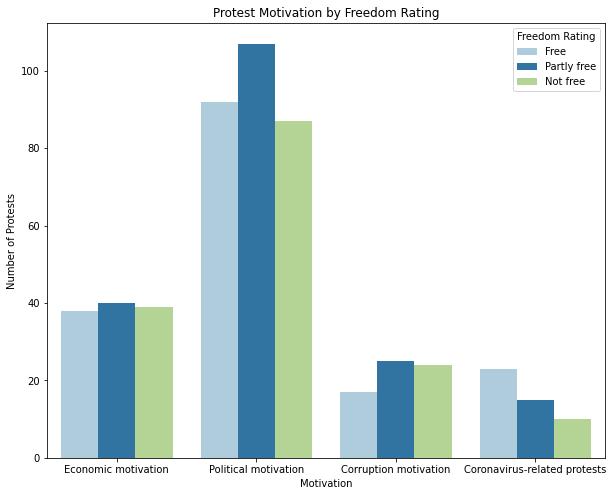

In [79]:
xticks = ["Economic motivation",
          "Political motivation",
          "Corruption motivation",
          "Coronavirus-related protests"]

fig = plt.figure(figsize = (10, 8))
ax = plt.subplot()
sns.barplot(data = motivation_counts, 
            x = "variable", 
            y = "value", 
            hue = "Freedom Rating", 
            palette = "Paired")
plt.xlabel("Motivation")
plt.ylabel("Number of Protests")
plt.title("Protest Motivation by Freedom Rating")
ax.set_xticklabels(xticks)
plt.savefig("Protest motivation by freedom rating")
plt.show()

#### Findings

Interestingly, Coronavirus related protests seem to go against the trend with free countries having the highest number of protests.

### Significant Outcomes

Let's just check that significant outcomes are what I think they are - positive results to the protests

In [80]:
#write function to display all significant outcomes 
def find_significant_outcomes(s):
    lst = list(s)
    for n in s:
        negative = re.findall(r"No policy", str(n))
        if negative:
            lst.remove(n)
    for i in lst:
        print(i)

In [81]:
#find_significant_outcomes(df.Outcomes)

It looks like all significant outcomes are when the protestors get what they want.

Now to find significant outcomes by motivation.

In [82]:
#select required columns
significant_outcomes = df[["Protests with a significant outcome",
                             "Economic motivation?",
                             "Political motivation?",
                             "Corruption motivation?",
                             "Coronavirus-related protests"]]

#group data by motivation and significant outcomes
outcomes_motivation_df = significant_outcomes.melt(
                                                id_vars = "Protests with a significant outcome"
                                                ).groupby(
                                                ["Protests with a significant outcome", "variable"]
                                                ).sum().reset_index()


#pivot table for graphing
outcomes_motivation_df_pivot = outcomes_motivation_df.pivot(
                                                        index = "variable", 
                                                        columns = "Protests with a significant outcome"
                                                        ).reset_index()

outcomes_motivation_df_pivot

variable value    
Protests with a significant outcome                                   0   1
0                                    Coronavirus-related protests    37  11
1                                          Corruption motivation?    37  29
2                                            Economic motivation?    74  43
3                                           Political motivation?   206  80

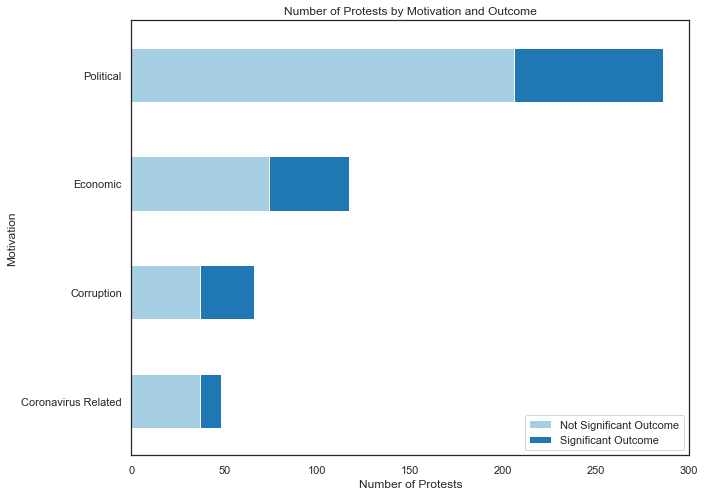

In [83]:
#set tick labels
motivations = ["Coronavirus Related", "Corruption", "Economic", "Political"]
#plot horizontal bar graph
sns.set_theme(palette = "Paired", style = "white")
ax1 = plt.subplot()
outcomes_motivation_df_pivot.plot(kind = "barh",
                                  title = ("Number of Protests by Motivation and Outcome"),
                                  ylabel = "Num protests",
                                  xlabel = "Motivation",
                                  yticks = [0, 1, 2, 3],
                                  ax = ax1,
                                  figsize = (10, 8),
                                  stacked = True)
ax1.set_yticklabels(motivations)
plt.xlabel("Number of Protests")
plt.legend(["Not Significant Outcome", "Significant Outcome"])
plt.savefig("Number of protests by motivation and outcome", bbox_inches='tight')
plt.show()

#### Get figures for percentage of successful protests

In [84]:
outcomes_motivation_df_pivot["% successful"] = outcomes_motivation_df_pivot["value"][1] / outcomes_motivation_df_pivot["value"].sum(axis = 1)

outcomes_motivation_df_pivot

variable value      \
Protests with a significant outcome                                   0   1   
0                                    Coronavirus-related protests    37  11   
1                                          Corruption motivation?    37  29   
2                                            Economic motivation?    74  43   
3                                           Political motivation?   206  80   

                                    % successful  
Protests with a significant outcome               
0                                       0.229167  
1                                       0.439394  
2                                       0.367521  
3                                       0.279720

#### Significant Outcomes by Freedom Rating

In [85]:
#get significant outcomes count by freedom rating
significant_freedom = pd.crosstab(df["Freedom Rating"], 
                                  df["Protests with a significant outcome"])

In [86]:
significant_freedom

Protests with a significant outcome,0,1
Freedom Rating,,
Free,78,31
Partly free,82,36
Not free,70,32


In [87]:
chi2, pval, dof, expected = chi2_contingency(significant_freedom)

In [88]:
print(pval)
print(expected)

0.8911055066934436
[[76.2006079  32.7993921 ]
 [82.49240122 35.50759878]
 [71.30699088 30.69300912]]


#### Findings

Corruption motivation had the highest proportion of successful outcomes but was one of the smallest categories.

Coronavirus motivated protests had the lowest proportion of successful outcomes and was the smallest category.

There was no significant difference between successful outcomes between countries of different freedom ratings.

#### Limitations

Some of the motivation data spans over multiple categories, for example a protest could have both political and ecomomic motivation. While I don't think it makes the data completely useless, it's worth bearing in mind.

### Large protests and Violent government response

In [89]:
#make a crosstab of large protests vs violent government responses
large_violent_contingency = pd.crosstab(df["Large protests (Over 100,000 protesting)"], df["Violent government response"])
#print crosstab
large_violent_contingency

Violent government response,0,1
"Large protests (Over 100,000 protesting)",,
0,208,71
1,31,19


#### Hypothesis testing

H_0 = Violent government responses to protests are independent to the size of protests.

H_1 = Violent government responses to protests are not completely independent to the size of protests being over 100,000 people.

/alpha A = 0.05

A p-value of less than 0.05 would lead us to reject the null hypothesis and conclude that violent government responses are not independent of protests being over 100,000 people.

In [90]:
chi2, pval, dof, expected = chi2_contingency(large_violent_contingency)

print(chi2, pval)
print(expected)

2.7596971992688255 0.09666653224627982
[[202.67781155  76.32218845]
 [ 36.32218845  13.67781155]]


The resultant p-value of 0.097 leads us to accept the null hypothesis and conclude that a violent government response is independent to whether a protest is over 100,000 people in size.

### Long protests and Violent government responses

In [91]:
#make a crosstab of long protests vs violent government responses
long_violent_contingency = pd.crosstab(df["Long protests (more than 3 months)"], 
                                       df["Violent government response"])
#print crosstab
long_violent_contingency

Violent government response,0,1
Long protests (more than 3 months),,
0,191,58
1,48,32


#### Hypothesis testing

H_0 = Violent government responses to protests are independent to the length of protests being over 3 months.

H_1 = Violent government responses to protests are not independent to the length of protests eing over 3 months.

/alpha A = 0.05

A p-value of less than 0.05 would lead us to reject the null hypothesis and conclude that violent government responses are not completely independent to the length of the protests.

In [92]:
chi2, pval, dof, expected = chi2_contingency(long_violent_contingency)

print(chi2, pval)
print(expected)

7.684256109164693 0.005570463672242339
[[180.88449848  68.11550152]
 [ 58.11550152  21.88449848]]


The resultant p-value is 0.006 leading us to accept the alternative hypothesis of violent government responses to protests not being independent to the length of protests.

#### Findings

A Chi square contingency test of Violent government responses against Large protests (over 100,000 people) concluded that these two factors are independent of each other.

A Chi square contingency test of Violent government response against Long protests (over 3 months) revealed that is it highly unlikely that these two factors aren't independent form each other. 






### Violence over time

In [93]:
df["Start Date"] = pd.to_datetime(df["Start Date"], format = "%b-%y")

In [94]:
sd_df = df[["Start Date", "Protest Name"]].groupby("Start Date").count().reset_index()
sd_df.tail()

,Start Date,Protest Name
60,2022-01-01,3
61,2022-02-01,4
62,2022-03-01,6
63,2022-04-01,3
64,2022-05-01,1


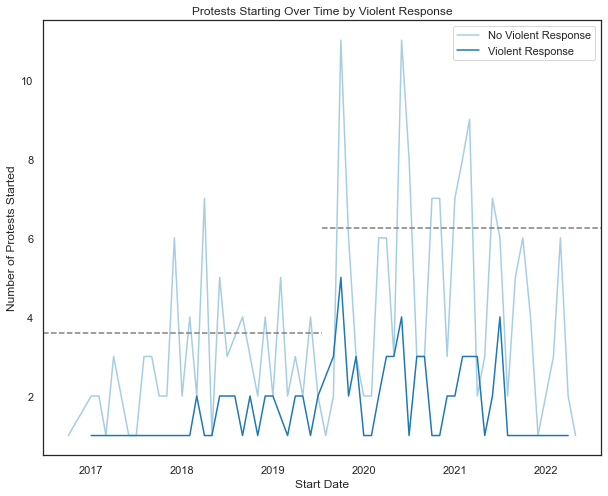

In [95]:
fig = plt.figure(figsize = (10, 8))
ax = sns.lineplot(x = df["Start Date"], 
                  y = df["Violent government response"], 
                  hue = df["Violent government response"], 
                  ci = None, 
                  estimator = "count")

ax.axhline(
    y = np.nanmean(sd_df[sd_df["Start Date"] < "2019-10-01"]["Protest Name"]),
    xmax = 0.5,
    c = "gray",
    ls = "--")
ax.axhline(
    y = np.nanmean(sd_df[sd_df["Start Date"] > "2019-10-01"]["Protest Name"]),
    xmin = 0.5,
    c = "gray",
    ls = "--")

plt.title("Protests Starting Over Time by Violent Response")
plt.ylabel("Number of Protests Started")
plt.legend(["No Violent Response", "Violent Response"])
plt.savefig("Protests Starting Over Time by Violent Response")
plt.show()

In [96]:
#get mean and total protests started per time period
print(np.nanmean(sd_df[sd_df["Start Date"] < "2019-10-01"]["Protest Name"]),
      np.sum(sd_df[sd_df["Start Date"] < "2019-10-01"]["Protest Name"]))
print(np.nanmean(sd_df[sd_df["Start Date"] > "2019-10-01"]["Protest Name"]),
      np.sum(sd_df[sd_df["Start Date"] > "2019-10-01"]["Protest Name"]))

3.606060606060606 119
6.258064516129032 194


In [97]:
#determine variance of pre and post 0ct 2019
print(variance(sd_df[sd_df["Start Date"] < "2019-10-01"]["Protest Name"]))
print(variance(sd_df[sd_df["Start Date"] > "2019-10-01"]["Protest Name"]))

3.1212121212121215
9.731182795698924


In [98]:
#run ttest on pre/post oct 2019 total numbers
tstat, pval = ttest_ind(sd_df[sd_df["Start Date"] < "2019-10-01"]["Protest Name"],
                        sd_df[sd_df["Start Date"] > "2019-10-01"]["Protest Name"])

print(pval)

8.177796435988765e-05


Significant difference as expected

#### Take Coronavirus related protests out to determine if this was the main driving factor of the increase

In [99]:
#get total number of coronavirus protests
df[df["Coronavirus-related protests"] == 1]["Protest Name"].count()

48

In [100]:
#take away coronavirus-related protests
194-48

146

In [101]:
#determine mean per month non covid protests post 10-2019
146/31

4.709677419354839

#### Split data into 2 groups and determine variance 

In [102]:
#define pre-october 2019 df
pre_10_2019 = sd_df[sd_df["Start Date"] < "2019-10-01"]

#define post-october 2019 non-covid related df
post_10_2019 = df[df["Coronavirus-related protests"] == 0][["Start Date",
                                                            "Protest Name"]].groupby("Start Date").count().reset_index()

In [103]:
#determine variance of each group df
print(f"Variance of Pre 10-2019 = {variance(pre_10_2019['Protest Name'])}")
print(f"Variance of Post 10-2019 = {variance(post_10_2019['Protest Name'])}")

Variance of Pre 10-2019 = 3.1212121212121215
Variance of Post 10-2019 = 6.628365384615385


In [104]:
print(f"The variance ratio is {6.62/3.12} which passes for equal variance")

The variance ratio is 2.121794871794872 which passes for equal variance


#### Perform 2 sample t test

H0 = There is no significant difference between the mean protests started between pre and post october 2019

H1 = There is a significant difference between the mean protests started etween pre and post october 2019

alpha = 0.05

In [105]:
tstat, pval = ttest_ind(pre_10_2019['Protest Name'], post_10_2019['Protest Name'])
print(tstat, pval)

-1.4356897524330485 0.15434104601279336


With a pval of 0.15, we can accept the null hypothesis that there was no significant difference between protest activity between pre and post October 2019, accounting for coronavirus protests.

### Protest Duration by Start Date

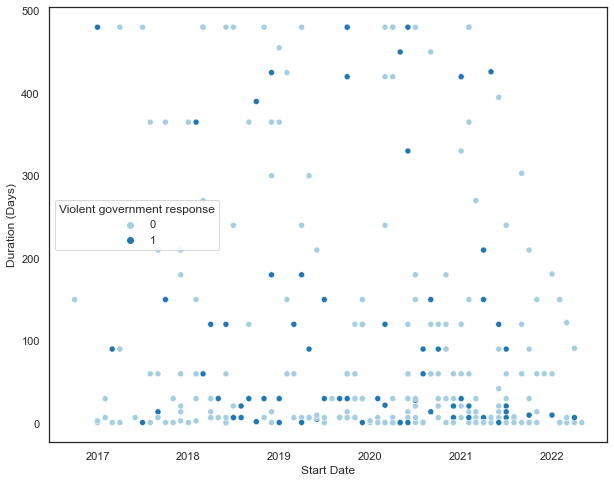

In [118]:
#plot scatter plot to check for correlation between start date and protest duration
fig = plt.figure(figsize = (10, 8))
ax = sns.scatterplot(x = df["Start Date"], 
                     y = df["Duration (Days)"],
                     hue = df["Violent government response"])

plt.show()

There seems to be no correlations to this data other than obvious groups of days, such as 30, 60, 90 days. 365/1 year and the 95percentile cap at just under 500 days.

## Export Clean Data For Use In Tableau

In [107]:
df.to_csv("clean_protest_data.csv")